<img src="https://platforma.gik.pw.edu.pl/themes/konkurs/logo.png">

# Deep learning w GIS, Maria Sokołowska

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.utils import to_categorical
import numpy as np
import tifffile as tiff
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, HTML
from sklearn import preprocessing

Using TensorFlow backend.


## Sieć neuronowa

<img src="https://chucksblog.typepad.com/.a/6a00d83451be8f69e201bb07e83109970d-800wi">
chucksblog.typepad.com

## Wczytanie danych

In [2]:
def shuffle_in_unison(a, b):
    """
    Miesza a, b i c, ale tak by indeksy dalej sobie odpowiadaly
    :param a: numpy array
    :param b: numpy array
    :param c: numpy array
    :return: pomieszane numpy arraye
    """
    assert len(a) == len(b)
    np.random.seed(42)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [3]:
def read_data(path):
    """
    Zwraca dataset (data), etykiety numeryczne (labels) i nazwy klas/katalogow (classes)
    data, labels -> numpy array
    classes -> lista
    :param path: sciezka do katalogu z katalogami z danymi
    """
    cls = 0
    classes = {}
    data = []
    labels = []
    names = []
    dirs = os.listdir(path)
    for dir in dirs:
        if dir in ["HerbaceousVegetation", "Highway"]:
            continue
        files = os.listdir(path + "/" + dir)
        for file in files:
            if not file.rsplit(".", 1)[1].lower() in ["tif"]:
                continue
            else:
                # wczytanie obrazu
                filepath = path + "/" + dir + "/" + file
                image = tiff.imread(filepath)
                data.append(image)
                labels.append(cls)
        classes[cls] = dir
        cls += 1

    # miesza dane i etykiety, ale tak by nadal sobie odpowiadaly
    data = np.stack(data)
    data, labels = shuffle_in_unison(np.array(data), np.array(labels))
    return data, labels, classes

In [4]:
data, labels, classes = read_data("/home/mery/tif")
print("Wymiar tensora z danymi wejściowymi: {}".format(data.shape))
print("Wymiar wektora z etykietami danych wejśćiowych: {}".format(labels.shape))


Wymiar tensora z danymi wejściowymi: (27000, 64, 64, 13)
Wymiar wektora z etykietami danych wejśćiowych: (27000,)


In [5]:
# OPTIONAL
# remove some channels
#remove_idx = [0,8,9,10]
remove_idx=[0,4,5,6,8,9,10,11,12]
for idx in sorted(remove_idx, reverse=True):
    data = np.concatenate(
        ( data[:, :, :, 0:idx],
          data[:, :, :, idx+1:] ),
        axis=3  )
print(data.shape)

(27000, 64, 64, 4)


[Text(0, 0, 'Pasture'),
 Text(0, 0, 'Industrial'),
 Text(0, 0, 'River'),
 Text(0, 0, 'Residential'),
 Text(0, 0, 'HerbaceousVegetation'),
 Text(0, 0, 'PermanentCrop'),
 Text(0, 0, 'Highway'),
 Text(0, 0, 'SeaLake'),
 Text(0, 0, 'AnnualCrop'),
 Text(0, 0, 'Forest')]

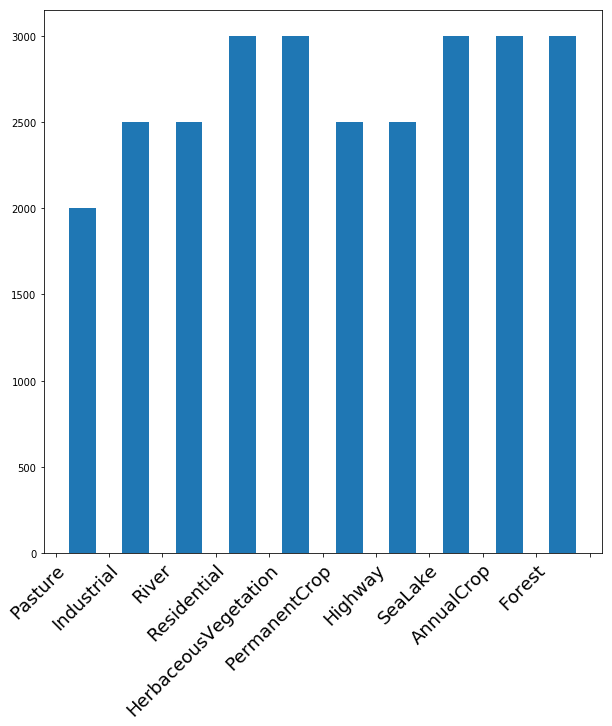

In [6]:
plt.figure(figsize=(10,10))
axes = plt.subplot()
counts, bins, patches = axes.hist(labels, rwidth=0.5)
axes.set_xticks(bins)
axes.set_xticklabels(list(classes.values()), rotation=45, rotation_mode="anchor", ha="right", fontsize=18)


## Podział danych na trenujące i walidacyjne

In [7]:
dataset_size = data.shape[0]
train_size = int(0.85 * dataset_size) # 90% datasetu (mozna tym manipulowac)
val_size = int(0.1 * dataset_size)
test_size = int(0.05 * dataset_size)
train_limit = train_size
val_limit = train_size + val_size
X_train = data[0:train_limit, ].astype('float32')
y_train = labels[0:train_limit].astype('float32')
X_val = data[train_limit:val_limit, ].astype('float32')
y_val = labels[train_limit:val_limit].astype('float32')
X_test = data[val_limit:, ].astype('float32')
y_test = labels[val_limit:].astype('float32')

In [8]:
dataset_size

27000

In [9]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((22950, 64, 64, 4),
 (22950,),
 (1350, 64, 64, 4),
 (1350,),
 (2700, 64, 64, 4),
 (2700,))

## Wyświetlenie próbki danych

In [10]:
# dataset_samples=['img/Pasture115.PNG', 'img/Forest633.PNG', 'img/Highway2160.PNG',
#                  'img/PernamentCrop2385.PNG', 'img/HerbaceousVegatation444.PNG']
# for idx in range(5):
#     image = X_train[idx, :, :,1]
#     fig = plt.figure(figsize=(15,15))
#     fig.add_subplot(1,2,1)
#     plt.imshow(image)
#     fig.add_subplot(1,2,2)
#     plt.imshow(Image.open(dataset_samples[idx]))
#     plt.title('Class: {}'.format(classes[y_train[idx]]))
#     plt.show()

## Normalizacja i kategoryzacja danych

In [11]:
def normalize(x):
    x_means = np.zeros(x.shape[0])
    x_stds=np.zeros(x.shape[0])
    
    for i in range(x.shape[0]):
        x_means[i]=x[i,:].mean()
        x_stds[i]=x[i,:].std()
    x_stds+=1e-5
    for i in range(x.shape[0]):
        x[i]-=x_means[i]
        x[i]/=x_stds[i]

In [12]:
normalize(X_train)
normalize(X_val)
normalize(X_test)


num_classes = np.unique(labels).shape[0]
if len(y_train.shape) == 1:
    y_train = to_categorical(y_train, num_classes)
    y_val = to_categorical(y_val, num_classes)
    y_test = to_categorical(y_test, num_classes)
    

## Konwolucyjna sieć neuronowa

<img src="https://devblogs.nvidia.com/wp-content/uploads/2015/11/hierarchical_features.png">
devblogs.nvidia.com

In [13]:
input_shape = X_train[0].shape

In [14]:

model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape),
        # wartosci w kernelu sa zazwyczaj z rozkladu gaussa
        # liczba filtrow to liczba nalozen kernela
    
        MaxPool2D(pool_size=(2, 2)),  # pooling na przefiltrowanym bierze max z okna 2x2 i zmniejsza rozmiar img

        Conv2D(filters=64, kernel_size=(3, 3)),  # conv2d i pooling na wyniku pierwszego zestawu
        MaxPool2D(pool_size=(2, 2)),

        Flatten(),  # obrazek po konwolucjach -> liczba pikseli x 1

        Dense(512, activation='relu'),  # fullyconnected ma 512 neuronow, dokladane do flatten, mozna te liczbe zmieniac

        Dense(num_classes, activation='softmax')
    ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## Trenowanie modelu

In [15]:
model.fit(
        X_train, y_train,
        batch_size=256, #dzielnik rozmiaru X_train
        epochs=10, #ok. 5-7
        validation_data=(X_val, y_val)
    )

Train on 22950 samples, validate on 2700 samples
Epoch 1/10
22950/22950 [==============================] - 24s 1ms/step - loss: 1.4226 - accuracy: 0.6362 - val_loss: 0.6482 - val_accuracy: 0.7733
Epoch 2/10
22950/22950 [==============================] - 23s 1ms/step - loss: 0.5887 - accuracy: 0.7966 - val_loss: 0.5349 - val_accuracy: 0.8100
Epoch 3/10
22950/22950 [==============================] - 23s 1ms/step - loss: 0.4540 - accuracy: 0.8405 - val_loss: 0.6104 - val_accuracy: 0.7630
Epoch 4/10
22950/22950 [==============================] - 23s 1ms/step - loss: 0.3426 - accuracy: 0.8852 - val_loss: 0.4531 - val_accuracy: 0.8430
Epoch 5/10
22950/22950 [==============================] - 23s 1ms/step - loss: 0.2777 - accuracy: 0.9062 - val_loss: 0.4265 - val_accuracy: 0.8500
Epoch 6/10
22950/22950 [==============================] - 23s 1ms/step - loss: 0.2424 - accuracy: 0.9192 - val_loss: 0.3800 - val_accuracy: 0.8752
Epoch 7/10
22950/22950 [==============================] - 23s 1ms/ste

## Testowanie

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)  # zwraca [loss, accuracy]

In [17]:
"Dokładność: {0:.2%}".format(score[1])

'Dokładność: 84.00%'

In [18]:
X_new = X_test[:5]
y_new_ground_truth = y_test[:5]
y_new = model.predict(X_new)
classes

{0: 'Pasture',
 1: 'Industrial',
 2: 'River',
 3: 'Residential',
 4: 'HerbaceousVegetation',
 5: 'PermanentCrop',
 6: 'Highway',
 7: 'SeaLake',
 8: 'AnnualCrop',
 9: 'Forest'}

Powinno być: PermanentCrop
Rozpoznano: AnnualCrop


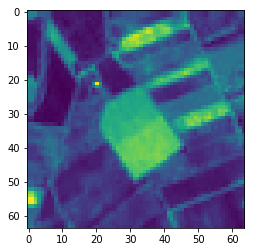

Powinno być: HerbaceousVegetation
Rozpoznano: HerbaceousVegetation


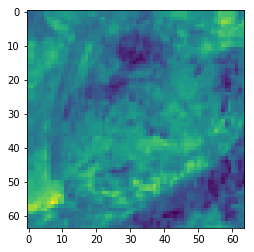

Powinno być: HerbaceousVegetation
Rozpoznano: HerbaceousVegetation


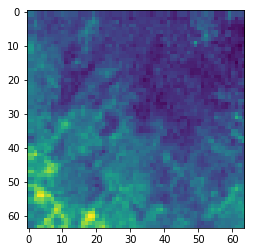

Powinno być: Highway
Rozpoznano: HerbaceousVegetation


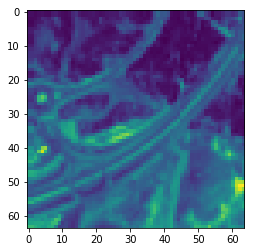

Powinno być: HerbaceousVegetation
Rozpoznano: HerbaceousVegetation


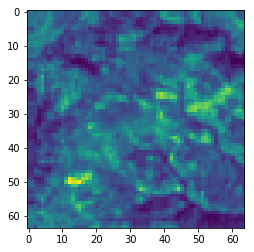

In [19]:
for i in range(len(X_new)):
    y_new_rounded = [ '%.2f' % elem for elem in y_new[i] ]
    y_new_ground_truth_rounded = [ '%.2f' % elem for elem in y_new_ground_truth[i] ]
    type(y_new_rounded)
    plt.imshow(X_test[i, :, :,1])
    print('Powinno być: {}'.format(classes[y_new_ground_truth_rounded.index(max(y_new_ground_truth_rounded))]))
    print('Rozpoznano: {}'.format(classes[y_new_rounded.index(max(y_new_rounded))]))
    plt.show()

## Save model to disk

In [20]:
model.save("/home/mery/saved_model_RGBI.h5")
np.save("X_test", X_test)
np.save("y_test", y_test)

In [21]:
y_test.shape

(1350, 10)

In [22]:
y_test[:5,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [23]:
X_test.shape

(1350, 64, 64, 13)